# aiReview

aiReview is an artificial intelligence-based system that creates a reviewer (in the form of an HTML file) from handwritten lecture notes. It uses optical character recognition (OCR) in converting an image of handwritten text into a machine-readable text file. Unlike other OCR software, it also features an annotation-conversion system that converts underlined words in the input with blanks and encircled words into bolded words.

This project is developed by: 

- A.V. Cayetano (THX)
- J. M. Choa (THX)
- H. A. Macalisang (THU)
- R. J. Portuguez (THW)

Thematic inspiration:
SDG 4 – Quality Education.

## Import packages

In [33]:
import numpy as np
import pandas as pd
import scipy
import cv2
from matplotlib import pyplot as plt
import ipynb.fs.defs.utils as utils
from PIL import Image, ImageFont, ImageDraw 
from IPython.display import display
from scipy.ndimage import interpolation
import glob
import os
import random
import statistics
import textwrap

## Methodology

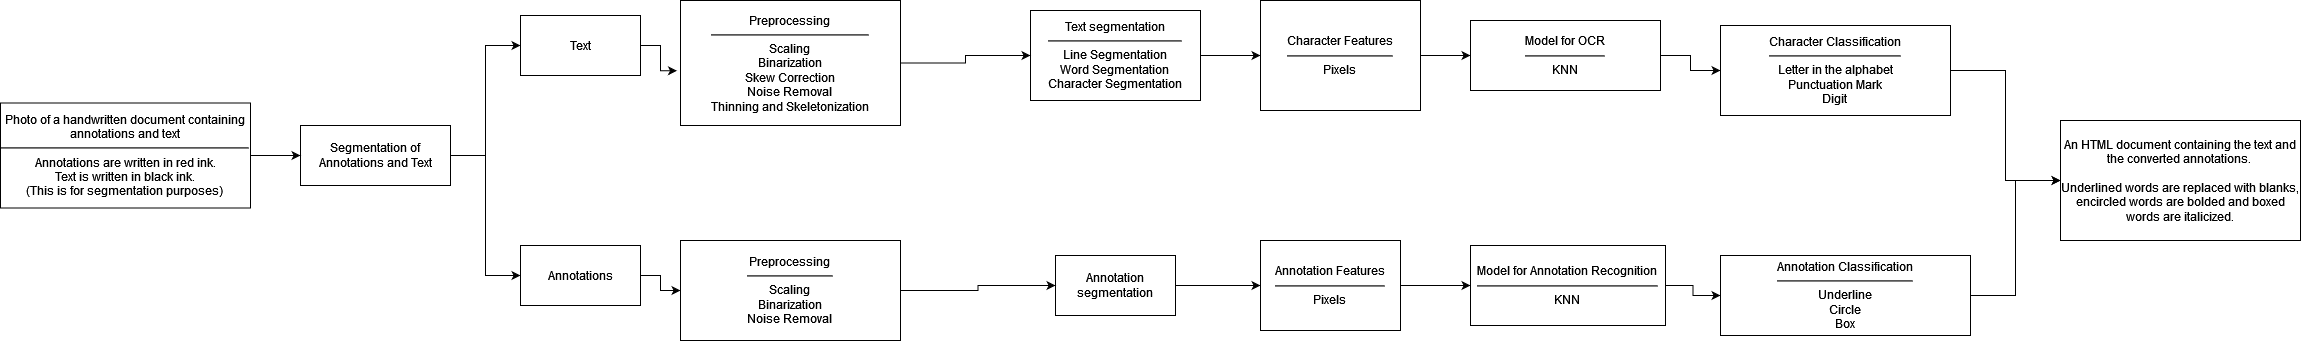

In [34]:
with Image.open("../media/method.png") as method_img:
    display(method_img)
    
    

# The image below is not updated. Will update soon.
 


## Load Test Data

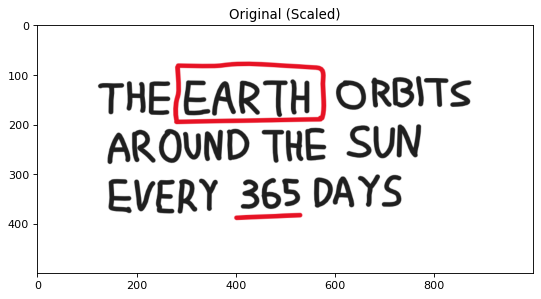

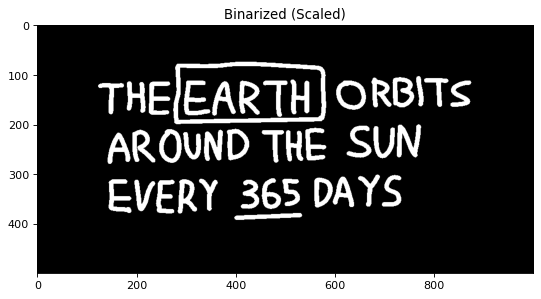

In [54]:
TARGET_HEIGHT = 500
TARGET_WIDTH = 1000


def resize(img):
    return cv2.resize(img, (TARGET_WIDTH, TARGET_HEIGHT))





class TestingSample:
    """
        TestingSample (input)
        
        Image:
        self.img
        self.img_bin
        
        Text part of the image:
        self.text_img_bin (temporary)
        self.text_img
        self.Text: Text()
        
        Annotation part of the image:
        self.anno_img_bin (temporary)
        self.anno_img
        self.Anno: Anno()
        
        
        
    """
    
    def __init__(self, path):
        self.img = cv2.imread(path)
        self.img = cv2.cvtColor(resize(self.img), cv2.COLOR_BGR2RGB)
        
        img_gs = cv2.cvtColor(self.img, cv2.COLOR_RGB2GRAY)
        _, self.img_bin = cv2.threshold(img_gs, 127, 255, cv2.THRESH_BINARY_INV)
        
test_1 = TestingSample("../input/test_17.png")
utils.plot_img(test_1.img, "Original (Scaled)", "rgb")
utils.plot_img(test_1.img_bin, "Binarized (Scaled)", "gray")



## Segmentation of Annotations and Text and Noise Removal

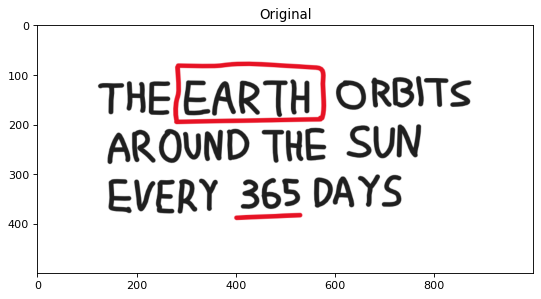

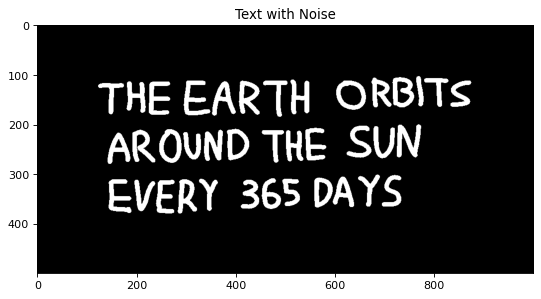

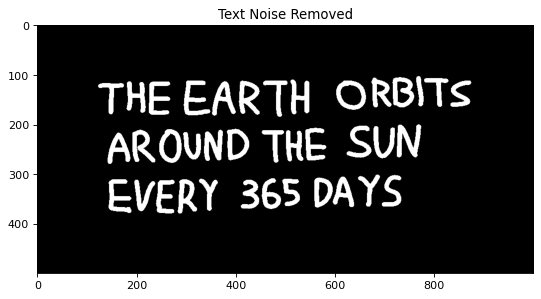

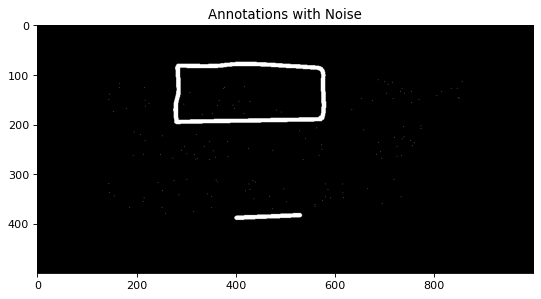

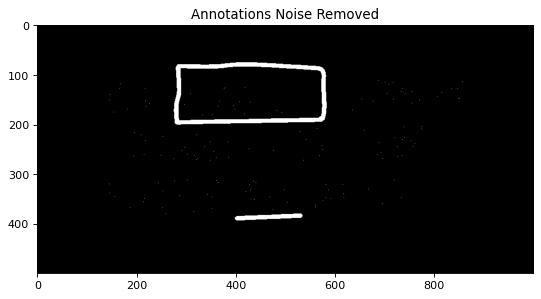

In [55]:
# References:
# https://docs.opencv.org/4.x/df/d9d/tutorial_py_colorspaces.html
# https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html
# https://docs.opencv.org/4.x/d5/d69/tutorial_py_non_local_means.html


def get_text(test_img):
    # filter all black inks
    test_img_hsv = cv2.cvtColor(test_img, cv2.COLOR_RGB2HSV)
    lower_text_color = np.array([0, 0, 0])
    upper_text_color = np.array([179, 44, 130])
    text_img = cv2.inRange(test_img_hsv, lower_text_color, upper_text_color)

    return text_img

def remove_noise(img_bin, kernel_size_open=(1, 1), kernel_size_close=(1, 1)):
    kernel_open = np.ones(kernel_size_open, np.uint8)
    kernel_close = np.ones(kernel_size_close, np.uint8)
    
    img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel_open)
    img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, kernel_close)
    
    img_bin = cv2.fastNlMeansDenoising(img_bin)
    return img_bin


def get_annotations(test_img_bin, text_img_bin):
    # filter all inks that are not text
    annotations_img = cv2.bitwise_xor(test_img_bin, text_img_bin)
    return annotations_img




utils.plot_img(test_1.img, "Original", "rgb")


test_1.text_img_bin = get_text(test_1.img)
utils.plot_img(test_1.text_img_bin, "Text with Noise", "gray")


test_1.text_img_bin = remove_noise(test_1.text_img_bin)
utils.plot_img(test_1.text_img_bin, "Text Noise Removed", "gray")


test_1.anno_img_bin = get_annotations(test_1.img_bin, test_1.text_img_bin)
utils.plot_img(test_1.anno_img_bin, "Annotations with Noise", "gray")


test_1.anno_img_bin = remove_noise(test_1.anno_img_bin, (1, 1), (2, 2))
utils.plot_img(test_1.anno_img_bin, "Annotations Noise Removed", "gray")


## Skew Correction

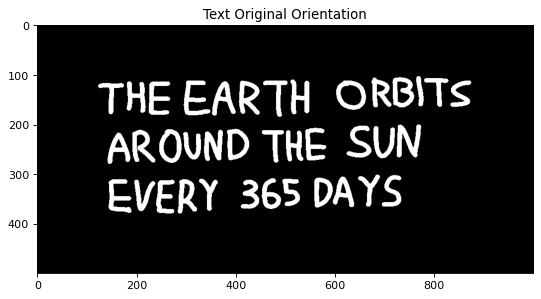

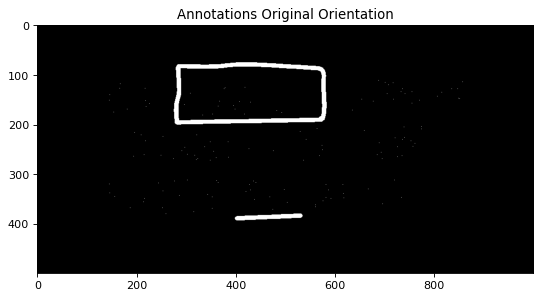

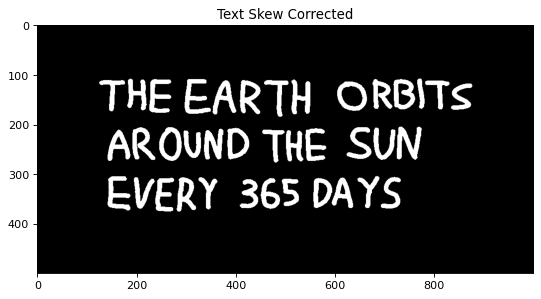

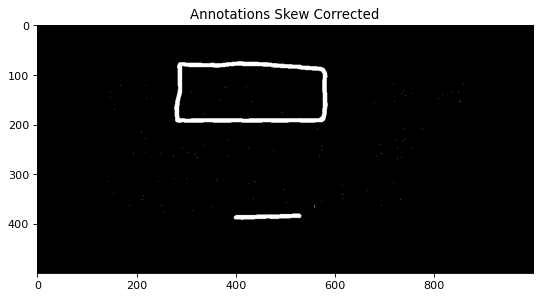

In [56]:
# References:
# https://pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/
# https://docs.opencv.org/4.x/da/d6e/tutorial_py_geometric_transformations.html


def skew_correct(text_img, anno_img=None):
    coords = np.column_stack(np.where(text_img > 0))
    angle = cv2.minAreaRect(coords)[-1]
    
    if angle > 45:
        angle = 90 - angle
    else:
        angle = -angle

    rows, cols = text_img.shape
    rotation = cv2.getRotationMatrix2D(((cols-1)/2, (rows-1)/2), angle, 1)

    new_text_img = cv2.warpAffine(text_img, rotation, (cols, rows))
    _, new_text_img = cv2.threshold(new_text_img, 127, 255, cv2.THRESH_BINARY)
    if anno_img is not None:
        new_anno_img = cv2.warpAffine(anno_img, rotation, (cols, rows))
        _, new_anno_img = cv2.threshold(new_anno_img, 127, 255, cv2.THRESH_BINARY)
        new_anno_img = remove_noise(new_anno_img, (1, 1), (5, 5))
    else:
        new_anno_img = None
        
    return new_text_img, new_anno_img



test_1.text_img, test_1.anno_img = skew_correct(test_1.text_img_bin, test_1.anno_img_bin)


utils.plot_img(test_1.text_img_bin, "Text Original Orientation", "gray")
utils.plot_img(test_1.anno_img_bin, "Annotations Original Orientation", "gray")

utils.plot_img(test_1.text_img, "Text Skew Corrected", "gray")
utils.plot_img(test_1.anno_img, "Annotations Skew Corrected", "gray")

## Text Segmentation

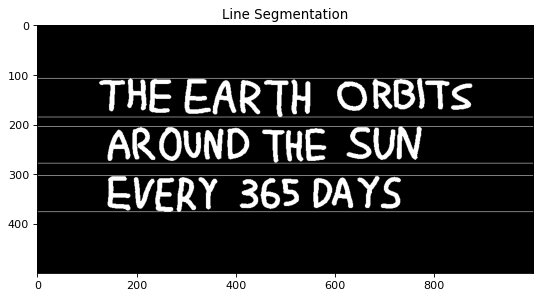

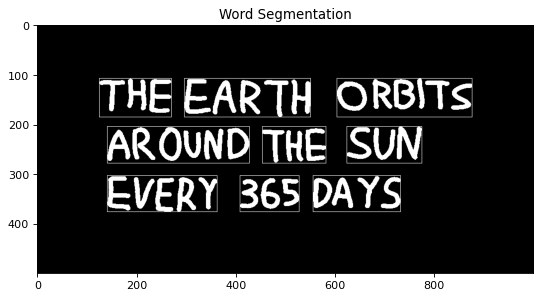

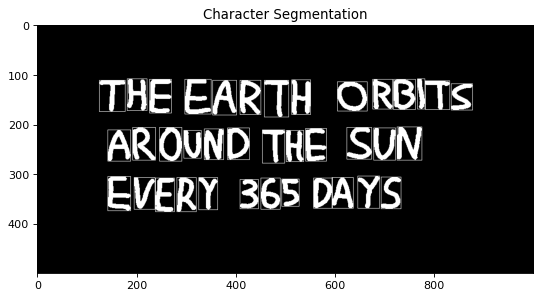

CHARACTERS:  [[((125, 111), (177, 174)), ((181, 108), (221, 172)), ((226, 109), (270, 177))], [((297, 109), (350, 179)), ((353, 111), (401, 181)), ((408, 111), (450, 180)), ((457, 111), (506, 185)), ((512, 110), (550, 180))], [((604, 114), (664, 173)), ((675, 109), (715, 169)), ((717, 109), (761, 170)), ((765, 108), (780, 169)), ((781, 112), (830, 170)), ((833, 118), (876, 171))], [((142, 211), (188, 274)), ((192, 206), (238, 272)), ((246, 206), (291, 274)), ((295, 212), (330, 268)), ((336, 209), (375, 271)), ((383, 207), (427, 271))], [((453, 211), (498, 278)), ((501, 212), (536, 275)), ((540, 208), (582, 274))], [((623, 206), (673, 270)), ((677, 207), (721, 272)), ((724, 205), (774, 272))], [((142, 305), (188, 374)), ((195, 307), (237, 371)), ((238, 308), (276, 376)), ((281, 307), (320, 376)), ((325, 307), (363, 372))], [((408, 311), (445, 370)), ((450, 308), (489, 371)), ((492, 310), (527, 365))], [((556, 308), (594, 369)), ((593, 307), (636, 369)), ((645, 304), (689, 369)), ((692, 

In [99]:

# THRESHOLDS:
ROW_PIXEL_MIN = 1
# we don't expect two characters on top of each other,
# so we don't have to put much restriction on minimum inter-line spaces
INTER_LINE_SPACE_MIN_Y = 10

COL_PIXEL_MIN = 5
INTER_CHAR_SPACE_MIN_X = 20 # threshold space between characters
INTRA_CHAR_SPACE_MIN_X = 1  # threshold space inside a character

NEIGHBORS_Y = 5



def plot_h_hist(h_hist, fig_id):
    x = [h for h in range(0, -1*(len(h_hist)), -1)]
    plt.figure(fig_id)
    plt.plot(h_hist, x)
    
def plot_v_hist(v_hist, fig_id):
    x = [h for h in range(np.size(v_hist))]
    plt.figure(fig_id)
    plt.plot(x, v_hist)


# Method:
# divide image into lines
# divide lines into words
# divide words to characters

def horizontal_hist(img):
    return np.sum(img, axis=1, keepdims=True) / 255

def vertical_hist(img):
    return np.sum(img, axis=0, keepdims=True) / 255

WHITE = (255, 255, 255)

# divide to lines
def find_lines(h_hist, img):
    lines = []
#     plot_h_hist(h_hist, 0) # optional
    spaces = []
    is_start = True
    s = None
    for i in range(len(h_hist)):
        if h_hist[i] < ROW_PIXEL_MIN: # row is empty (doesn't have enough pixels to count as containing text)
            if is_start:
                s = i # s = start of next set of consecutive spaces
                is_start = False
            # if row is empty but it isn't the starting space, 
            # do nothing (it becomes part of the current set of spaces)
        elif not is_start:
            # IMPORTANT: if lines are close enough, it may count them as one line
            # we have to make the INTER_LINE_SPACE_MIN_Y low to keep this from happening
            if i - 1 - s > INTER_LINE_SPACE_MIN_Y:
                spaces.append((s, i - 1))
                is_start = True
            else:
                is_start = True
    
    spaces.append([s, img.shape[1]])
    # lines are located between spaces
    for s in range(len(spaces) - 1):
        lines.append((spaces[s][1], spaces[s+1][0]))
    
    
    return lines


def draw_lines(img, lines, title):
    line_segmented = img.copy()
    for l in range(len(lines)):
        line_segmented = cv2.rectangle(line_segmented, 
                                        (0, lines[l][0]), 
                                        (img.shape[1], lines[l][1]), WHITE, 1)
    utils.plot_img(line_segmented, title, "gray")

    
# divide to words
def find_words(lines, img, min_width=None):
    words = []
#     fig_id = 0 # optional
    for line in lines:
        words.append([])
        start_y = line[0] 
        end_y = line[1]
        line_v_hist = vertical_hist(img[start_y:end_y+1,:]).flatten()
#         plot_v_hist(line_v_hist, fig_id) # optional
#         fig_id += 1 # optional
        
        spaces = []
        is_start = True
        s = None
        for i in range(len(line_v_hist)):
            if line_v_hist[i] < COL_PIXEL_MIN:
                if is_start:

                    s = i
                    is_start = False
            elif not is_start:
                if i - 1 - s > INTER_CHAR_SPACE_MIN_X:
                    spaces.append((s, i - 1))
                    is_start = True
                else:
                    is_start = True
                    
        spaces.append((s, img.shape[1]))
        # words are located between spaces
        for s in range(len(spaces) - 1):
            if min_width is None:
                words[-1].append((spaces[s][1], spaces[s+1][0]))
            elif spaces[s+1][0] - spaces[s][1] > min_width:
                words[-1].append((spaces[s][1], spaces[s+1][0]))
                
            
    
        

    return words
    
def draw_words(img, lines, words, title):
    word_segmented = img.copy()
    for l in range(len(lines)):
        for w in range(len(words[l])):
            word_segmented = cv2.rectangle(word_segmented, 
                                            (words[l][w][0], lines[l][0]), 
                                            (words[l][w][1], lines[l][1]), WHITE, 1)
    utils.plot_img(word_segmented, title, "gray")

# divide to characters
def find_chars(lines, words, img):
    chars = []
    for l in range(len(lines)):
        for w in range(len(words[l])):
            chars_in_word = []
            word_x1 = words[l][w][0]
            word_x2 = words[l][w][1]
            word_y1 = lines[l][0] 
            word_y2 = lines[l][1]
            
            word = img[word_y1:word_y2+1, word_x1:word_x2+1]
            
            num_chars, labelled_word = cv2.connectedComponents(word)
            
            labels = np.unique(labelled_word)
            
            for label in labels:
                if label == 0:
                    continue
                else:
                    coords = np.column_stack(np.where(labelled_word == label))
                    char = cv2.boundingRect(coords) # (y, x, height, width)
                    
                    # char should be ((x1, y1), (x2, y2))
                    char_x1 = word_x1 + char[1]
                    char_y1 = word_y1 + char[0]
                    char_x2 = char_x1 + char[3]
                    char_y2 = char_y1 + char[2]
                    
                    chars_in_word.append((
                        (char_x1, char_y1),
                        (char_x2, char_y2)
                    ))
                    
                    
            chars_in_word.sort(key=lambda x: x[0][0])
            chars.append(chars_in_word)
    
    return chars

def draw_chars(img, chars, title):
    char_segmented = img.copy()
    
    for w in range(len(chars)):
        for c in range(len(chars[w])):
            char_segmented = cv2.rectangle(char_segmented, chars[w][c][0], chars[w][c][1], WHITE, 1)
    utils.plot_img(char_segmented, title, "gray")


# used in detecting annotations; annotations have a minimum width of min_width_word
def find_min_width_word(words):
    min_width = 9999999999
    for l in range(len(words)):
        for w in range(len(words[l])):
            if words[l][w][1] - words[l][w][0] < min_width:
                min_width = words[l][w][1] - words[l][w][0]
    return min_width


class Text:
    """
        The text part of the input.
        Contains information about the lines, words, and characters of the input.
    
    """
    
    def __init__(self, img):
        self.img = img
        
        self.h_hist = horizontal_hist(img).flatten()
        self.lines = find_lines(self.h_hist, self.img)
        self.words = find_words(self.lines, self.img)
        self.chars = find_chars(self.lines, self.words, self.img)
#         self.refined_chars = refine_chars(self.chars, self.img)
        
        self.min_width_word = find_min_width_word(self.words)
        

test_1.text = Text(test_1.text_img)

draw_lines(test_1.text.img, test_1.text.lines, "Line Segmentation")
draw_words(test_1.text.img, test_1.text.lines, test_1.text.words, "Word Segmentation")
draw_chars(test_1.text.img, test_1.text.chars, "Character Segmentation")


# TestingSample.Text.chars is the set of coordinates of the rectangles that bound each character.
print("CHARACTERS: ", test_1.text.chars)


## Annotations Segmentation

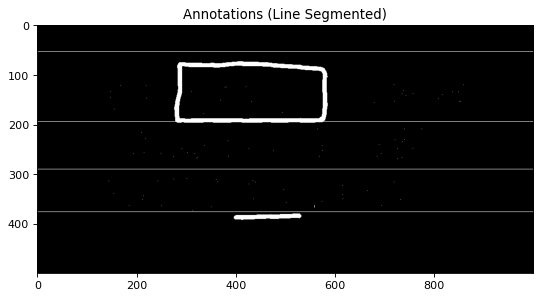

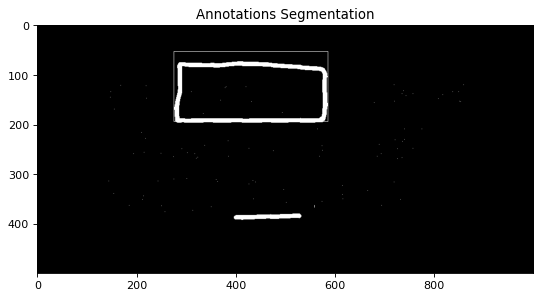

ANNOTATIONS:  [((275, 53), (585, 194))]


In [98]:
# THRESHOLDS
NEIGHBORS_X = 5

V_LINE_PIXEL_MIN = 10
H_LINE_PIXEL_MIN = 3


def find_annotations(img, text):
    fig_id = 0
    anno_min_width = text.min_width_word
    lines = text.lines.copy()
    lines.insert(0, (0, 0))
    lines.append((lines[-1][1], lines[-1][1]))

    
    anno_lines = []
    for l in range(1, len(lines) - 1):
        s_y = (lines[l-1][1] + lines[l][0]) // 2
        e_y = (lines[l][1] + lines[l+1][0]) // 2
        anno_lines.append((s_y, e_y))

    draw_lines(img, anno_lines, "Annotations (Line Segmented)")
    
    anno = find_words(anno_lines, img, anno_min_width)
    
    draw_words(img, anno_lines, anno, "Annotations Segmentation")
    
    annotations = []
    for l in range(len(anno_lines)):
        for a in range(len(anno[l])):
            annotations.append(((anno[l][a][0], anno_lines[l][0]), (anno[l][a][1], anno_lines[l][1])))
    

    return annotations



class Anno:
    def __init__(self, img, text):
        self.img = img
        self.annotations = find_annotations(img, text)
        

test_1.anno = Anno(test_1.anno_img, test_1.text)

# TestingSample.Anno.annotations is the set of coordinates of the rectangles that bound each annotation.
print("ANNOTATIONS: ", test_1.anno.annotations)

    

## Training Data (Characters)

CLASSES:  0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ
Display random training samples: 
Random class:  5


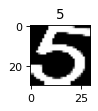

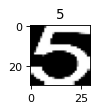

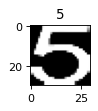

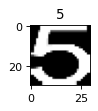

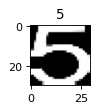

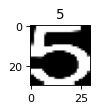

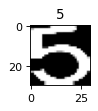

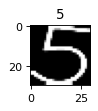

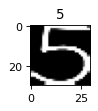

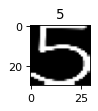

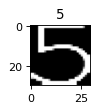

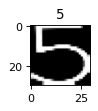

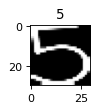

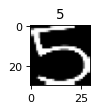

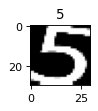

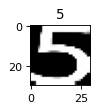

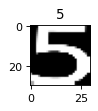

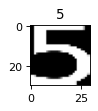

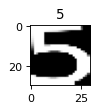

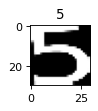

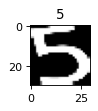

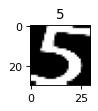

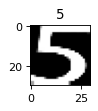

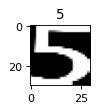

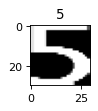

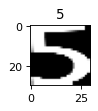

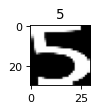

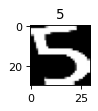

In [94]:
# FEATURE VECTOR: an array of size SIZE corresponding to the pixels of a character or an annotation
SIZE = (30, 30)
TRAIN_DATA_CLASS_SIZE = 600 # size of training data per class
KERNEL = np.ones((3, 3),np.uint8) # used in eroding or dilating an image


TEXT_TRAINING_DATA_PATH = "../training/ocr/"

# crop an image to focus only on the area with pixels
def crop(img):
    h_hist = horizontal_hist(img).flatten()
    v_hist = vertical_hist(img).flatten()
    
    s_x = 0
    e_x = len(v_hist) - 1
    start_found = False
    end_found = False
    while s_x < e_x and not (start_found and end_found):
        if not start_found:
            if v_hist[s_x] > 0:
                start_found = True
            else:
                s_x += 1
                
        if not end_found:
            if v_hist[e_x] > 0:
                end_found = True
            else:
                e_x -= 1
            
    s_y = 0
    e_y = len(h_hist) - 1
    start_found = False
    end_found = False
    while s_y < e_y and not (start_found and end_found):
        if not start_found:
            if h_hist[s_y] > 0:
                start_found = True
            else:
                s_y += 1
                
        if not end_found:
            if h_hist[e_y] > 0:
                end_found = True
            else:
                e_y -= 1
                
    
    return img[s_y:e_y+1,s_x:e_x+1]

# rescale the image to the size of the feature vector
def rescale(img):
    return cv2.resize(img, SIZE)

def add_margins(img): # this adds black margins to equalize the dimensions of the image
    shape = img.shape
    if shape[0] > shape[1]: # height > width
        if (shape[0] - shape[1]) % 2 == 0: # difference can be split equally
            img = cv2.copyMakeBorder(img,
                0, 0, (shape[0] - shape[1]) // 2, (shape[0] - shape[1]) // 2, cv2.BORDER_CONSTANT, 0)
        else: # difference is odd, add extra 1-pixel width margin to one side
            img = cv2.copyMakeBorder(img,
                0, 0, (shape[0] - shape[1]) // 2, (shape[0] - shape[1]) // 2 + 1, cv2.BORDER_CONSTANT, 0)
    elif shape[1] > shape[0]: # width > height
        if (shape[1] - shape[0]) % 2 == 0:
            img = cv2.copyMakeBorder(img,
                (shape[1] - shape[0]) // 2, (shape[1] - shape[0]) // 2, 0, 0, cv2.BORDER_CONSTANT, 0)
        else:
            img = cv2.copyMakeBorder(img,
                (shape[1] - shape[0]) // 2, (shape[1] - shape[0]) // 2 + 1, 0, 0, cv2.BORDER_CONSTANT, 0)
    
    return img


class TrainingSample:
    """
        Labelled TrainingSample
    
    """
    def __init__(self, path, label):
        self.img = cv2.imread(path)
        self.path = path
        self.img_gs = cv2.bitwise_not(cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY))
        
        
        # processing
        self.char = crop(self.img_gs)
#         self.char = add_margins(self.char)
        self.char = rescale(self.char)
        self.char = cv2.dilate(self.char, KERNEL)
        self.char = cv2.erode(self.char, KERNEL, iterations=1)
#         self.char, _ = skew_correct(self.char)
        
        self.label = label
        

nums = "".join([str(i) for i in range(10)])
letters = "abcdefghijklmnopqrstuvwxyz"


TEXT_CLASSES = nums + letters.upper()
print("CLASSES: ", TEXT_CLASSES)


count = {c: 0 for c in TEXT_CLASSES}
text_training_samples = []


for c in TEXT_CLASSES:
    # characters are already organized in folders
    SPECIFIC_PATH = TEXT_TRAINING_DATA_PATH + c + '/'
    text_dataset = os.listdir(SPECIFIC_PATH)
    for img_path in text_dataset:
        if count[c] < TRAIN_DATA_CLASS_SIZE:
            text_training_samples.append(TrainingSample(SPECIFIC_PATH + img_path, c))
            count[c] += 1
        else:
            break
    
            


print("Display random training samples: ")
random_class = random.choice(TEXT_CLASSES)

print("Random class: ", random_class)

for sample in text_training_samples:
    if sample.label == random_class:
        utils.plot_img(sample.char, random_class, "gray", (1, 1))





## Our KNN Implementation

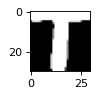

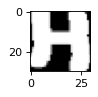

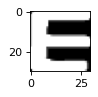

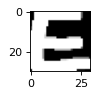

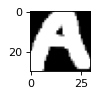

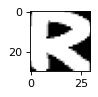

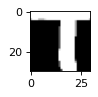

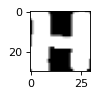

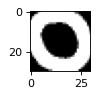

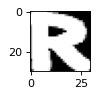

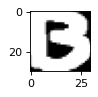

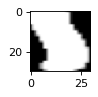

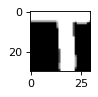

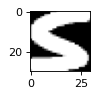

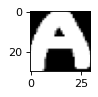

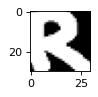

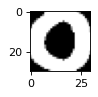

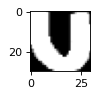

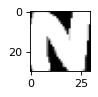

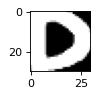

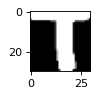

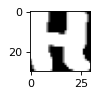

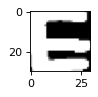

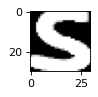

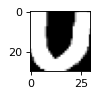

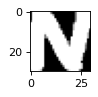

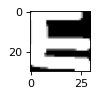

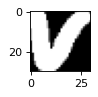

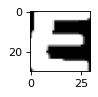

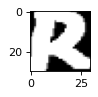

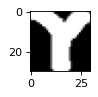

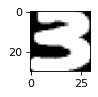

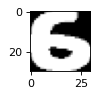

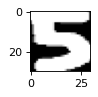

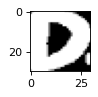

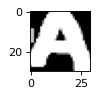

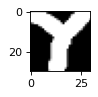

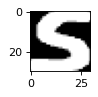

TEXT OUTPUT: 
THE EARTH ORB5TS AROUND TRE SUN EVERY 365 DAYS

TARGET OUTPUT: 
THE EARTH ORBITS AROUND THE SUN EVERY 365 DAYS

ACCURACY: 
Score: 36/38
0.9474


In [97]:
# References:
# https://docs.opencv.org/3.4/d2/de8/group__core__array.html
# https://docs.opencv.org/3.4/d2/de8/group__core__array.html#gad12cefbcb5291cf958a85b4b67b6149f


class KNN:
    def __init__(self, k, training_samples):
        self.training_samples = training_samples
        self.k = k
    
    def classify(self, testing_sample):
        """
            KNN Algorithm:
            1) Compute for the difference between the TestingSample and each TrainingSample
            2) Select K-nearest TrainingSamples
            3) Find the most common class in the K-nearest TrainingSamples
        
        """
        diffs = []
        for training_sample in self.training_samples:
            diffs.append((training_sample.label, cv2.norm(testing_sample, training_sample.char, cv2.NORM_HAMMING)))
        
        diffs.sort(key=lambda x: x[1])

        k_nearest = [i[0] for i in diffs[:self.k]]

        return statistics.mode(k_nearest)

        

text_knn = KNN(20, text_training_samples)


text_output = []
for word in test_1.text.chars:
    for char in word:
        test_char = test_1.text.img[char[0][1]:char[1][1]+1,char[0][0]:char[1][0]+1]
        
        # processing
#         test_char = add_margins(test_char)
        test_char = rescale(test_char)
        test_char = cv2.dilate(test_char, KERNEL)
        
        utils.plot_img(test_char, "", "gray", (1, 1))

        text_output.append(text_knn.classify(test_char))
    text_output.append(" ")


print("TEXT OUTPUT: ")
text_output = "".join(text_output).rstrip()
print(text_output)
print()


print("TARGET OUTPUT: ")
target_text = "THE EARTH ORBITS AROUND THE SUN EVERY 365 DAYS"
print(target_text)

print()



def compute_ocr_accuracy(output, target):
    output = output.replace(" ", "")
    target = target.replace(" ", "")
    
    correct = 0
    length = min(len(output), len(target))
    for i in range(length):
        if output[i] == target[i]:
            correct += 1
    print("Score: {}/{}".format(correct, length))
    return correct / length

print("ACCURACY: ")
print(round(compute_ocr_accuracy(text_output, target_text), 4))



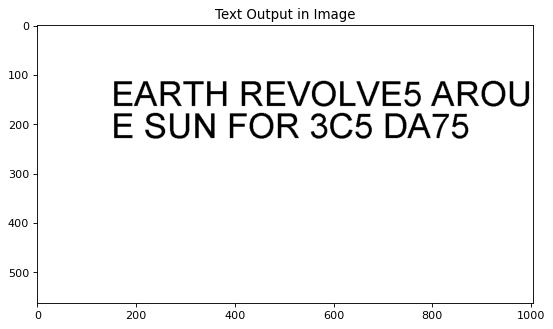

In [17]:
res = Image.open("../media/white_bg.png")
draw = ImageDraw.Draw(res) 
font = ImageFont.truetype("arial.ttf", 70) 

lines = textwrap.wrap(text_output, width=25)
y_text = 100
for line in lines:
    width, height = font.getsize(line)
    draw.text((150, y_text), line, font=font)
    y_text += height
res.save("../output/own_res.png")
img2 = Image.open("../output/own_res.png")
utils.plot_img(img2, "Text Output in Image", "rgb")

## OpenCV KNN Implementation

TrainingSamples shape:  (1001, 900)
Responses shape:  (1001, 1)



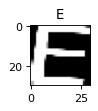

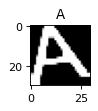

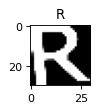

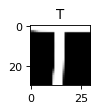

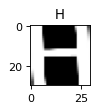

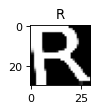

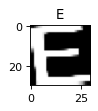

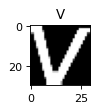

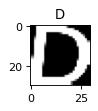

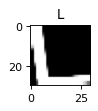

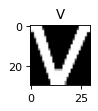

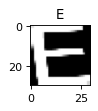

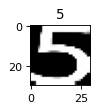

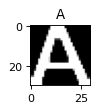

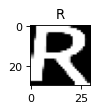

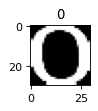

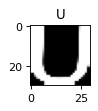

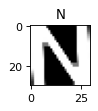

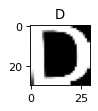

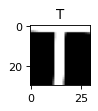

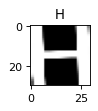

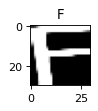

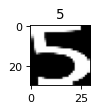

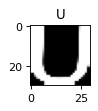

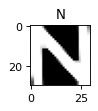

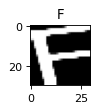

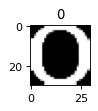

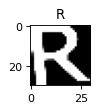

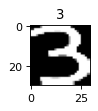

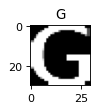

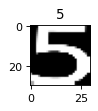

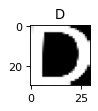

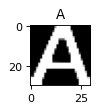

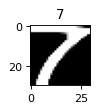

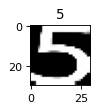

TEXT OUTPUT: 
EARTH REVDLVE5 AR0U ND TH F 5UN F0R 3G5 DA75

TARGET OUTPUT: 
EARTH REVOLVES AROUND THE SUN FOR 365 DAYS

ACCURACY: 
Score: 26/35
0.7428571428571429


In [18]:
# https://docs.opencv.org/4.x/d5/d26/tutorial_py_knn_understanding.html


opencv_text_training_samples = np.array([i.char.flatten() for i in text_training_samples], np.float32)
print("TrainingSamples shape: ", opencv_text_training_samples.shape)


opencv_text_responses = np.array(
    [i for i, e in enumerate(text_training_samples)], np.float32).reshape(len(text_training_samples), 1)


print("Responses shape: ", opencv_text_responses.shape)
print()

opencv_knn = cv2.ml.KNearest_create()

# The KNN Implementation of OpenCV


opencv_knn.train(opencv_text_training_samples, cv2.ml.ROW_SAMPLE, opencv_text_responses)


text_output = []
for word in test_1.text.chars:
    for char in word:
        test_char = test_1.text.img[char[0][1]:char[1][1]+1,char[0][0]:char[1][0]+1]
        
#         test_char = add_margins(test_char)
        
        test_char = cv2.dilate(rescale(test_char), KERNEL).flatten()
        
        test_char = np.float32(test_char.reshape(1, len(test_char)))

        _, results, _, _ = opencv_knn.findNearest(test_char, 1)

        nearest_training_sample = text_training_samples[int(results[0][0])]
        utils.plot_img(nearest_training_sample.char, nearest_training_sample.label, "gray", (1, 1))
        text_output.append(nearest_training_sample.label)
    text_output.append(" ")


print("TEXT OUTPUT: ")
text_output = "".join(text_output).rstrip()
print(text_output)
print()


print("TARGET OUTPUT: ")
# target_text = "The Earth orbits around the Sun every 365 days"
target_text = "EARTH REVOLVES AROUND THE SUN FOR 365 DAYS"
print(target_text)

print()


print("ACCURACY: ")
print(compute_ocr_accuracy(text_output, target_text))




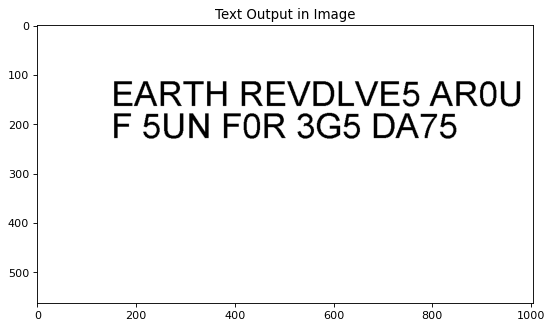

In [19]:
res1 = Image.open("../media/white_bg.png")
draw = ImageDraw.Draw(res1) 
font = ImageFont.truetype("arial.ttf", 70) 

lines = textwrap.wrap(text_output, width=25)
y_text = 100
for line in lines:
    width, height = font.getsize(line)
    draw.text((150, y_text), line, font=font)
    y_text += height
res1.save("../output/opencv_res.png")
img3 = Image.open("../output/opencv_res.png")
utils.plot_img(img3, "Text Output in Image", "rgb")

# Annotations Training

In [20]:
# FEATURE VECTOR: an array of size SIZE corresponding to the pixels of a character or an annotation
SIZE = (30, 30)
TRAIN_DATA_CLASS_SIZE = 600 # size of training data per class
KERNEL = np.ones((3, 3),np.uint8) # used in eroding or dilating an image


# TEXT_TRAINING_DATA_PATH = "../data/Synthetic Character Set/images/"
RECT_TRAINING_DATA_PATH = "../data/Annotations Set/rectangles/"

# crop an image to focus only on the area with pixels
def crop(img):
    h_hist = horizontal_hist(img).flatten()
    v_hist = vertical_hist(img).flatten()
    
    s_x = 0
    e_x = len(v_hist) - 1
    start_found = False
    end_found = False
    while s_x < e_x and not (start_found and end_found):
        if not start_found:
            if v_hist[s_x] > 0:
                start_found = True
            else:
                s_x += 1
                
        if not end_found:
            if v_hist[e_x] > 0:
                end_found = True
            else:
                e_x -= 1
            
    s_y = 0
    e_y = len(h_hist) - 1
    start_found = False
    end_found = False
    while s_y < e_y and not (start_found and end_found):
        if not start_found:
            if h_hist[s_y] > 0:
                start_found = True
            else:
                s_y += 1
                
        if not end_found:
            if h_hist[e_y] > 0:
                end_found = True
            else:
                e_y -= 1
                
    
    return img[s_y:e_y+1,s_x:e_x+1]

# rescale the image to the size of the feature vector
def rescale(img):
    return cv2.resize(img, SIZE)

def add_margins(img): # this adds black margins to equalize the dimensions of the image
    shape = img.shape
    if shape[0] > shape[1]: # height > width
        if (shape[0] - shape[1]) % 2 == 0: # difference can be split equally
            img = cv2.copyMakeBorder(img,
                0, 0, (shape[0] - shape[1]) // 2, (shape[0] - shape[1]) // 2, cv2.BORDER_CONSTANT, 0)
        else: # difference is odd, add extra 1-pixel width margin to one side
            img = cv2.copyMakeBorder(img,
                0, 0, (shape[0] - shape[1]) // 2, (shape[0] - shape[1]) // 2 + 1, cv2.BORDER_CONSTANT, 0)
    elif shape[1] > shape[0]: # width > height
        if (shape[1] - shape[0]) % 2 == 0:
            img = cv2.copyMakeBorder(img,
                (shape[1] - shape[0]) // 2, (shape[1] - shape[0]) // 2, 0, 0, cv2.BORDER_CONSTANT, 0)
        else:
            img = cv2.copyMakeBorder(img,
                (shape[1] - shape[0]) // 2, (shape[1] - shape[0]) // 2 + 1, 0, 0, cv2.BORDER_CONSTANT, 0)
    
    return img


class TrainingSample:
    """
        Labelled TrainingSample
    
    """
    
    def __init__(self, path, label):
        self.img = cv2.imread(path)
        self.path = path
        self.img_gs = cv2.bitwise_not(cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY))
        
        
        # processing
        self.char = crop(self.img_gs)
        self.char = add_margins(self.char)
        #self.char = rescale(self.char)
        #self.char = cv2.dilate(self.char, KERNEL)
        #self.char = cv2.erode(self.char, KERNEL, iterations=1)
#         self.char, _ = skew_correct(self.char)
        
        self.label = label
        

k = 11
print(k)

# TEXT_CLASSES = nums + letters + letters.upper()
#TEXT_CLASSES = nums + letters.upper() # standard OCR dataset doesn't contain small letters
#print("CLASSES: ", TEXT_CLASSES)


count = 0

rect_training_samples = []

# For Synthetic Character Set
'''
text_dataset = os.listdir(TEXT_TRAINING_DATA_PATH)

for c in TEXT_CLASSES:
    for img_path in text_dataset:
        if count[c] < TRAIN_DATA_CLASS_SIZE:
            if img_path.startswith("image_{}".format(c)):
                text_training_samples.append(TrainingSample(TEXT_TRAINING_DATA_PATH + img_path, c))
                count[c] += 1
        else:
            break
'''

# For standard OCR dataset
    # characters are already organized in folders
SPECIFIC_PATH = RECT_TRAINING_DATA_PATH
rect_dataset = os.listdir(SPECIFIC_PATH)
for img_path in rect_dataset:
    if count < TRAIN_DATA_CLASS_SIZE:
        rect_training_samples.append(TrainingSample(SPECIFIC_PATH + img_path, c))
        count += 1
    else:
        break
    
            
# print("Random Train Data:")
# choice = random.choice(text_train_data)

# utils.plot_img(choice.char, choice.label, "gray")


print("Display training samples: ")

random_class = "2"


for sample in rect_training_samples:
        utils.plot_img(sample.char, random_class, "black", (1, 1))





11


FileNotFoundError: [WinError 3] The system cannot find the path specified: '../data/Annotations Set/rectangles/'

# Annotations KNN

((528, 22), (608, 154))


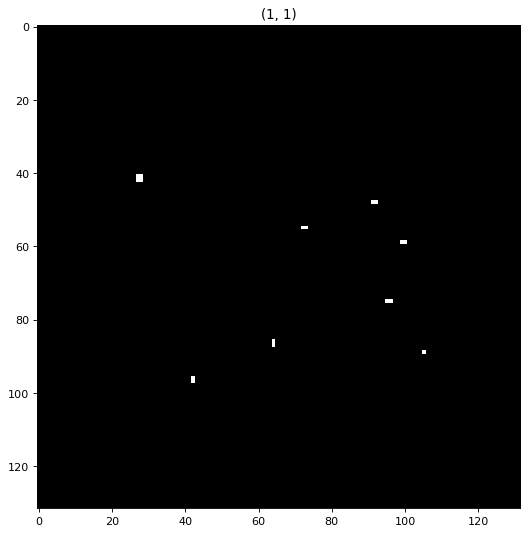

StatisticsError: no mode for empty data

In [21]:
# References:
# https://docs.opencv.org/3.4/d2/de8/group__core__array.html
# https://docs.opencv.org/3.4/d2/de8/group__core__array.html#gad12cefbcb5291cf958a85b4b67b6149f


class KNN:
    def __init__(self, k, training_samples):
        self.training_samples = training_samples
        self.k = k
    
    def classify(self, testing_sample):
        """
            KNN Algorithm:
            1) Compute for the difference between the TestingSample and each TrainingSample
            2) Select K-nearest TrainingSamples
            3) Find the most common class in the K-nearest TrainingSamples
        
        """
        diffs = []
        for training_sample in self.training_samples:
            diffs.append((training_sample.char, cv2.norm(testing_sample, training_sample.char, cv2.NORM_HAMMING)))
        
        diffs.sort(key=lambda x: x[1])

        k_nearest = [i[0] for i in diffs[:self.k]]

        return statistics.mode(k_nearest)

        

rect_knn = KNN(10, rect_training_samples)


rect_output = []
for recta in test_1.anno.annotations:
        print(recta)
        rect = test_1.anno.img[recta[0][1]:recta[1][1],recta[0][0]:recta[1][0]]
        
        # processing
        rect = add_margins(rect)
        
        utils.plot_img(rect, (1, 1))

        rect_output.append(rect_knn.classify(rect))
        rect_output.append(" ")


print("ANNO OUTPUT: ")
rect_output = "".join(rect_output).rstrip()
print(rect_output)
print()


print("TARGET OUTPUT: ")
# target_text = "The Earth orbits around the Sun every 365 days"
target_text = "THIS IS A SENTENCE WITH ONLY CAPITAL LETTERS AND NO SMALL LETTERS"
print(target_text)

print()



def compute_ocr_accuracy(output, target):
    correct = 0
    # alignment is done to account for possibly misaligned words (example: "The Earth" and "Th Earth")
    out_a = 0 # text_output alignment; increases if output has extra characters to realign words
    targ_a = 0 # target_text alignment; increases if output has missing characters to realign words
    for i in range(min(len(output), len(target))):
        '''
        # original accuracy checker + spaces not counted + no alignment
        if output[i] == target_text[i] and output[i] != ' ' and target_text[i] != ' ':
                correct += 1
        '''
        if i + out_a >= len(output) or i + targ_a >= len(target): # avoid IndexError
            break
        if output[i + out_a] != ' ' and target[i + targ_a] != ' ':
            if output[i + out_a] == target[i + targ_a]: # if both characters are the same and not spaces
                correct += 1
        elif output[i + out_a] == ' ' and target[i + targ_a] != ' ':
            targ_a += target[i + targ_a:].index(' ') # this makes it so both the output and target are at the space
        elif output[i + out_a] != ' ' and target[i + targ_a] == ' ':
            out_a += output[i + out_a:].index(' ') # this makes it so both the output and target are at the space
        # if both are spaces, skip (do not count spaces)
        
    # max means extra / missing characters are counted
    # spaces aren't counted so it is subtracted
    print("Score: {}/{}".format(correct, max(len(output) - output.count(' '), len(target) - target.count(' '))))
    return correct / max(len(output) - output.count(' '), len(target) - target.count(' '))
    

print("ACCURACY: ")
print(compute_ocr_accuracy(text_output, target_text))

